# 1. Weather data

The weather data was taken from https://mesowest.utah.edu/ and represents data from 2019. (At least one row for every hour)

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

spark = SparkSession.builder.appName('BigData').getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [30]:
weather = spark.read.option("header", True).csv("hdfs://localhost:9000/Data/D.C/New/weather.csv", sep=',', comment = '#')
weather = weather.dropna(subset=['Station_ID', 'Date_Time'])
weather = weather.dropna(subset=['air_temp_set_1', 'wind_speed_set_1'])

In [31]:
weather.printSchema()

root
 |-- Station_ID: string (nullable = true)
 |-- Date_Time: string (nullable = true)
 |-- altimeter_set_1: string (nullable = true)
 |-- air_temp_set_1: string (nullable = true)
 |-- dew_point_temperature_set_1: string (nullable = true)
 |-- relative_humidity_set_1: string (nullable = true)
 |-- wind_speed_set_1: string (nullable = true)
 |-- wind_direction_set_1: string (nullable = true)
 |-- wind_gust_set_1: string (nullable = true)
 |-- snow_depth_set_1: string (nullable = true)
 |-- sea_level_pressure_set_1: string (nullable = true)
 |-- weather_cond_code_set_1: string (nullable = true)
 |-- cloud_layer_3_code_set_1: string (nullable = true)
 |-- pressure_tendency_set_1: string (nullable = true)
 |-- precip_accum_one_hour_set_1: string (nullable = true)
 |-- precip_accum_three_hour_set_1: string (nullable = true)
 |-- cloud_layer_1_code_set_1: string (nullable = true)
 |-- cloud_layer_2_code_set_1: string (nullable = true)
 |-- precip_accum_six_hour_set_1: string (nullable = tru

In [32]:
weather

Station_ID,Date_Time,altimeter_set_1,air_temp_set_1,dew_point_temperature_set_1,relative_humidity_set_1,wind_speed_set_1,wind_direction_set_1,wind_gust_set_1,snow_depth_set_1,sea_level_pressure_set_1,weather_cond_code_set_1,cloud_layer_3_code_set_1,pressure_tendency_set_1,precip_accum_one_hour_set_1,precip_accum_three_hour_set_1,cloud_layer_1_code_set_1,cloud_layer_2_code_set_1,precip_accum_six_hour_set_1,precip_accum_24_hour_set_1,visibility_set_1,metar_remark_set_1,metar_set_1,air_temp_high_6_hour_set_1,air_temp_low_6_hour_set_1,peak_wind_speed_set_1,ceiling_set_1,pressure_change_code_set_1,air_temp_high_24_hour_set_1,air_temp_low_24_hour_set_1,peak_wind_direction_set_1,dew_point_temperature_set_1d,cloud_layer_1_set_1d,cloud_layer_3_set_1d,cloud_layer_2_set_1d,wind_chill_set_1d,weather_summary_set_1d,wind_cardinal_direction_set_1d,pressure_set_1d,sea_level_pressure_set_1d,heat_index_set_1d,weather_condition_set_1d
KADW,12/31/2018 04:56 UTC,30.26,34.52,32.36,91.7,0.0,0.0,null,null,30.29,null,null,null,null,null,1.0,null,null,null,10.0,null,METAR KADW 310456...,null,null,null,null,null,46.94,31.82,null,32.32,null,null,null,null,clear,N,29.95,30.05,null,null
KADW,12/31/2018 05:56 UTC,30.26,35.6,32.18,87.21,3.44,160.0,null,null,30.29,null,null,3000.0,null,null,1903.0,null,null,null,10.0,null,KADW 310556Z AUTO...,38.3,31.82,null,19000.0,null,null,null,null,32.13,null,null,null,null,broken,SSE,29.95,30.05,null,null
KADW,12/31/2018 06:56 UTC,30.27,36.32,33.44,89.16,3.44,130.0,null,null,30.29,null,null,null,null,null,1902.0,null,null,null,10.0,null,METAR KADW 310656...,null,null,null,null,null,null,null,null,33.39,null,null,null,null,scattered,SE,29.96,30.05,null,null
KADW,12/31/2018 07:56 UTC,30.28,34.88,33.08,93.05,0.0,0.0,null,null,30.31,null,null,null,null,null,1902.0,null,null,null,10.0,null,METAR KADW 310756...,null,null,null,null,null,null,null,null,33.05,null,null,null,null,scattered,N,29.97,30.07,null,null
KADW,12/31/2018 08:46 UTC,30.26,37.4,35.6,93.13,3.44,120.0,null,null,30.29,null,null,null,null,null,223.0,null,null,null,10.0,null,KADW 310846Z AUTO...,null,null,null,2200.0,null,null,null,null,35.57,null,null,null,null,broken,ESE,29.95,30.02,null,null
KADW,12/31/2018 08:56 UTC,30.26,35.96,34.34,93.76,3.44,100.0,null,null,30.29,null,null,1.0,null,null,223.0,null,null,null,10.0,null,METAR KADW 310856...,null,null,null,2200.0,null,null,null,null,34.31,null,null,null,null,broken,E,29.95,30.03,null,null
KADW,12/31/2018 09:16 UTC,30.24,37.4,35.6,93.13,4.61,120.0,null,null,30.27,null,null,null,null,null,194.0,null,null,null,10.0,null,SPECI KADW 310916...,null,null,null,1900.0,0.0,null,null,null,35.57,null,null,null,null,overcast,ESE,29.93,30.0,null,null
KADW,12/31/2018 09:56 UTC,30.25,37.58,35.78,93.14,0.0,0.0,null,null,30.27,null,null,null,null,null,164.0,null,null,null,10.0,null,KADW 310956Z AUTO...,null,null,null,1600.0,null,null,null,null,35.75,null,null,null,null,overcast,N,29.94,30.01,null,null
KADW,12/31/2018 10:56 UTC,30.27,38.48,37.22,95.17,4.61,140.0,null,null,30.29,null,null,null,null,null,164.0,null,null,null,10.0,null,METAR KADW 311056...,null,null,null,1600.0,null,null,null,null,37.2,null,null,null,null,overcast,SE,29.96,30.01,null,null
KADW,12/31/2018 11:56 UTC,30.27,40.64,38.84,93.23,8.05,130.0,null,null,30.29,null,null,3003.0,null,null,154.0,null,null,null,10.0,null,METAR KADW 311156...,40.64,34.34,null,1500.0,null,null,null,null,38.81,null,null,null,37.22,overcast,SE,29.96,29.99,null,null


In [33]:
weather_short = weather.withColumn('Date_Time', weather.Date_Time.substr(0, 16))

weather_cast = weather_short.withColumn('Date_Time', F.to_timestamp(weather_short.Date_Time, "MM/dd/yyyy HH:mm"))
weather_cast = weather_cast.withColumn('air_temp', weather_cast.air_temp_set_1.cast(DoubleType()))
weather_cast = weather_cast.withColumn('wind_speed', weather_cast.wind_speed_set_1.cast(DoubleType()))
weather_cast = weather_cast.withColumn('visibility', weather_cast.visibility_set_1.cast(DoubleType()))
weather_cast = weather_cast.withColumn('weather_summary', weather_cast.weather_summary_set_1d)
weather_cast = weather_cast.withColumn('weather_condition', weather_cast.weather_condition_set_1d)

In [34]:
weather = weather_cast
weather = weather.select('Date_Time', 'air_temp', 'wind_speed', 'weather_summary', 'weather_condition', 'visibility')

In [35]:
weather

Date_Time,air_temp,wind_speed,weather_summary,weather_condition,visibility
2018-12-31 04:56:00,34.52,0.0,clear,null,10.0
2018-12-31 05:56:00,35.6,3.44,broken,null,10.0
2018-12-31 06:56:00,36.32,3.44,scattered,null,10.0
2018-12-31 07:56:00,34.88,0.0,scattered,null,10.0
2018-12-31 08:46:00,37.4,3.44,broken,null,10.0
2018-12-31 08:56:00,35.96,3.44,broken,null,10.0
2018-12-31 09:16:00,37.4,4.61,overcast,null,10.0
2018-12-31 09:56:00,37.58,0.0,overcast,null,10.0
2018-12-31 10:56:00,38.48,4.61,overcast,null,10.0
2018-12-31 11:56:00,40.64,8.05,overcast,null,10.0


Next, we can show all the possible values for weather description showing in the attained data.

In [36]:
weather.select('weather_summary').distinct()

weather_summary
fog
drizzle
heavy rain/thunde...
"heavy rain,mist,t..."
ice fog
thin scattered
thunder
"light drizzle,mis..."
"light rain,light ..."
light rain shower...


In [37]:
rain_data = weather.filter(weather.weather_summary.rlike('rain'))

In [38]:
rain_data.count()

1872

In [39]:
weather.count()

13600

We want to map different descriptions to a fixed set of classes: a simpler explanation of the data. For that task, we create a new column - weather_class.

In [40]:


weather = weather.withColumn('weather_class', F.when(weather.weather_summary.rlike('(clear|scattered|sunny|obscured)'), 'sunny').otherwise(weather.weather_summary))
weather = weather.withColumn('weather_class', F.when(weather.weather_summary.rlike('(broken|overcast|cloudy)'), 'cloudy').otherwise(weather.weather_class))
weather = weather.withColumn('weather_class', F.when(weather.weather_summary.rlike('(light (drizzle|rain))|rain|drizzle'), 'light rain').otherwise(weather.weather_class))
weather = weather.withColumn('weather_class', F.when(weather.weather_summary.rlike('(heavy (drizzle|rain))|heavy_rain'), 'heavy rain').otherwise(weather.weather_class))
weather = weather.withColumn('weather_class', F.when(weather.weather_class.rlike('snow'), 'snowy').otherwise(weather.weather_class))
weather = weather.withColumn('weather_class', F.when(weather.weather_class.rlike('ice'), 'icy').otherwise(weather.weather_class))
weather = weather.withColumn('weather_class', F.when(weather.weather_class.rlike('thunder|squalls'), 'stormy').otherwise(weather.weather_class))
weather = weather.withColumn('weather_class', F.when(weather.weather_class.rlike('haze|mist|fog'), 'foggy').otherwise(weather.weather_class))
weather = weather.withColumn('weather_class', F.when(weather.weather_summary.isNull(), 'sunny').otherwise(weather.weather_class))


In [41]:
weather

Date_Time,air_temp,wind_speed,weather_summary,weather_condition,visibility,weather_class
2018-12-31 04:56:00,34.52,0.0,clear,null,10.0,sunny
2018-12-31 05:56:00,35.6,3.44,broken,null,10.0,cloudy
2018-12-31 06:56:00,36.32,3.44,scattered,null,10.0,sunny
2018-12-31 07:56:00,34.88,0.0,scattered,null,10.0,sunny
2018-12-31 08:46:00,37.4,3.44,broken,null,10.0,cloudy
2018-12-31 08:56:00,35.96,3.44,broken,null,10.0,cloudy
2018-12-31 09:16:00,37.4,4.61,overcast,null,10.0,cloudy
2018-12-31 09:56:00,37.58,0.0,overcast,null,10.0,cloudy
2018-12-31 10:56:00,38.48,4.61,overcast,null,10.0,cloudy
2018-12-31 11:56:00,40.64,8.05,overcast,null,10.0,cloudy


In [42]:
weather.select('weather_class').distinct()

weather_class
icy
snowy
stormy
light rain
heavy rain
sunny
cloudy
foggy


In [43]:
class_labels = [str(row.weather_class) for row in weather.select('weather_class').distinct().collect()]
class_counts = [weather.filter(weather.weather_class.like(label)).count() for label in class_labels]

In [44]:
weather.filter(weather.weather_class.like("sunny")).count()

6148

In [45]:
weather.filter(weather.weather_class.like("cloudy")).count()


3068

In [46]:
weather.filter(weather.weather_class.rlike("rain")).count()

2444

In [47]:
weather.filter(weather.weather_class.like("stormy")).count()

154

In [48]:
print(class_counts)
print(class_labels)

[28, 399, 154, 2103, 341, 6148, 3068, 1359]
['icy', 'snowy', 'stormy', 'light rain', 'heavy rain', 'sunny', 'cloudy', 'foggy']


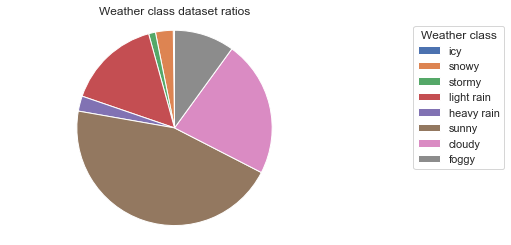

In [49]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = class_labels
sizes = class_counts

fig1, ax1 = plt.subplots()
wedges, texts = ax1.pie(sizes, labels=None,
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.legend(wedges, labels,
          title="Weather class",
          loc="top left", bbox_to_anchor=(1, 0, 0.5, 1))

ax1.set_title("Weather class dataset ratios")

plt.show()

In [50]:
#Here we filter by date
dates = ("04/01/2019",  "09/30/2019")
date_from, date_to = [F.to_timestamp(F.lit(s), "MM/dd/yyyy") for s in dates]
summer_months = weather.where((weather.Date_Time > date_from) & (weather.Date_Time < date_to))
display(summer_months)

Date_Time,air_temp,wind_speed,weather_summary,weather_condition,visibility,weather_class
2019-04-01 00:56:00,42.44,16.11,clear,null,10.0,sunny
2019-04-01 01:56:00,40.64,18.41,thin scattered,null,10.0,sunny
2019-04-01 02:56:00,38.3,18.41,thin scattered,null,10.0,sunny
2019-04-01 03:56:00,34.7,23.02,clear,null,10.0,sunny
2019-04-01 04:56:00,33.44,17.27,clear,null,10.0,sunny
2019-04-01 05:56:00,32.72,14.97,thin scattered,null,10.0,sunny
2019-04-01 06:56:00,32.54,14.97,clear,null,10.0,sunny
2019-04-01 07:56:00,32.54,23.02,clear,null,10.0,sunny
2019-04-01 08:56:00,32.0,16.11,clear,null,10.0,sunny
2019-04-01 09:56:00,31.82,17.27,clear,null,10.0,sunny


In [51]:

summer_class_labels = [str(row.weather_class) for row in summer_months.select('weather_class').distinct().collect()]
summer_class_counts = [summer_months.filter(summer_months.weather_class.like(label)).count() for label in summer_class_labels]

In [52]:
summer_class_labels
summer_class_counts

[148, 827, 237, 3459, 1325, 478]

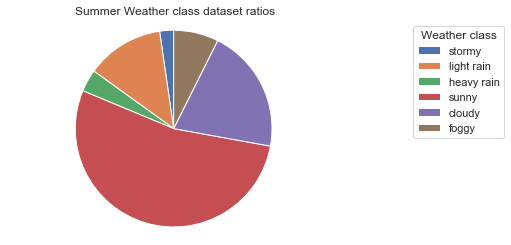

In [53]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = summer_class_labels
sizes = summer_class_counts

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=None,
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.legend(wedges, labels,
          title="Weather class",
          loc="top left", bbox_to_anchor=(1, 0, 0.5, 1))

ax1.set_title("Summer Weather class dataset ratios")

plt.show()

Text(0.5, 0.98, 'Weather classes histogram')

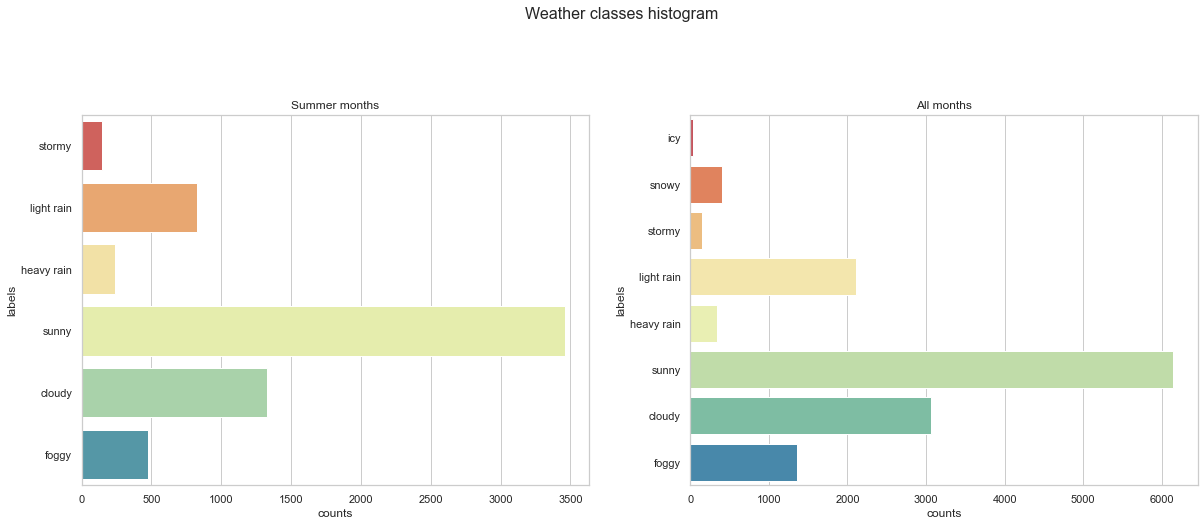

In [54]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

sns.set(style="whitegrid")
#sns.set_color_codes("Spectral")

source_data = pd.DataFrame(data = np.concatenate((np.array(class_counts).reshape(-1, 1), np.array(class_labels).reshape(-1, 1)), axis = 1), columns = ['counts', 'labels']).reset_index()
summer_data = pd.DataFrame(data = np.concatenate((np.array(summer_class_counts).reshape(-1, 1), np.array(summer_class_labels).reshape(-1, 1)), axis = 1), columns = ['counts', 'labels']).reset_index()

plt.figure(2, figsize=(20,15))
the_grid = GridSpec(2, 2)

plt.subplot(the_grid[0, 1],  title='All months')
sns.barplot(x='counts',y='labels', data=source_data, palette='Spectral')
plt.subplot(the_grid[0, 0], title='Summer months')
sns.barplot(x='counts',y='labels', data=summer_data, palette='Spectral')

plt.suptitle('Weather classes histogram', fontsize=16)

In [57]:
    temp_summary = weather.select([F.min("air_temp"), F.max("air_temp"), F.mean("air_temp"), F.stddev("air_temp")])
    display(temp_summary)
    wind_summary = weather.select([F.min("wind_speed"), F.max("wind_speed"), F.mean("wind_speed"), F.stddev("wind_speed")])
    display(wind_summary)
    visibility_summary = weather.select([F.min("visibility"), F.max("visibility"), F.mean("visibility"), F.stddev("visibility")])
    display(visibility_summary)

min(air_temp),max(air_temp),avg(air_temp),stddev_samp(air_temp)
7.16,98.42,56.33384264705889,17.88260568337722


min(wind_speed),max(wind_speed),avg(wind_speed),stddev_samp(wind_speed)
0.0,42.57,7.331980147059754,5.7084131419904995


min(visibility),max(visibility),avg(visibility),stddev_samp(visibility)
0.12,10.0,8.360902604090043,3.0773479118084355
